In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import hdbscan
from sklearn.manifold import TSNE

from tqdm import tqdm
import sys

sys.path.append("../scripts")
from data import SmallPatchesDataset, get_filenames
from models import AutoEncoder

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
filenames = get_filenames(25)
dataset = SmallPatchesDataset(filenames)
dl = torch.utils.data.DataLoader(dataset, batch_size = 64)

In [3]:
def plot_sample(sample, ax = None):
    img = sample
    img = img.permute(1, 2, 0).detach().cpu().numpy()
    if ax is None:
        plt.imshow(img)
        plt.axis(False)
        plt.show()
    else:
        ax.imshow(img)
        
def visualize_cluster_samples(k, clusters, n_samples = 9):
    ncols = 5
    nrows = k // 5 + (k % 5 > 0)
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * 4, nrows * 4))
    axs = axs.flat
    [ax.set_axis_off() for ax in axs]

    for i in range(k):
        axs[i].set_title(f"Samples of cluster {i}")
        samples = clusters == i
        if samples.sum() == 0:
            continue
        
        random_sample = np.random.choice(np.where(samples)[0], min(n_samples, samples.sum()))
        samples_per_row = int(np.sqrt(n_samples))
        img = torch.zeros((3, 224 * samples_per_row, 224 *samples_per_row))
        for j, idx in enumerate(random_sample):
            img[:, (j // samples_per_row) * 224: (j // samples_per_row + 1) * 224, (j % samples_per_row) * 224: (j % samples_per_row + 1) * 224] = dataset[idx][0]

        plot_sample(img, axs[i])
    plt.suptitle(f"Samples with k = {k}")


In [4]:
embeddings = {}
embeddings_proj = {}

for latent_dim in [10, 32, 64]:
    model = AutoEncoder(latent_dim, encoder_arch= "resnet50", decoder_layers_per_block = [3] * 5)
    model.load_state_dict(torch.load(f"../models/AE_resnet50_{latent_dim}/model.pt"));
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    embeddings[latent_dim] = []
    # get embeddings
    for batch, _ in tqdm(dl):
        batch = batch.to(device)
        batch_size = batch.shape[0]
        z = model(batch)[0].detach().cpu().numpy().reshape(batch_size, -1)
        embeddings[latent_dim].append(z)
    embeddings[latent_dim] = np.concatenate(embeddings[latent_dim])
    embeddings_proj[latent_dim] = TSNE().fit_transform(embeddings[latent_dim])

  0%|          | 0/157 [00:00<?, ?it/s]/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/157 [00:00<?, ?it/s]/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the

In [30]:
def analyze_hdbscan_params(data, min_cluster_size_list, min_samples_list):
    fig, axs = plt.subplots(nrows = len(min_cluster_size_list), ncols = len(min_samples_list), figsize = (10, 10))
    for i, min_cluster_size in enumerate(min_cluster_size_list):
        for j, min_samples in enumerate(min_samples_list):
            if min_samples > min_cluster_size:
                axs[i, j].set_axis_off()
                continue
            cls = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
            cls.fit(data)

            axs[i, j].set_title(f"min_cluster_size {min_cluster_size}\nmin_samples {min_samples}")
            height, x = np.histogram(cls.labels_, bins = np.arange(cls.labels_.max() + 2))
            axs[i, j].bar(x = x[:-1], height = height)

    plt.tight_layout()
    plt.show()

In [24]:
def get_fraction_samples(data, frac = [0.01, 0.025, 0.05, 0.1]):
    return [int(data.shape[0] * r) for r in frac]

## Latent dim = 10

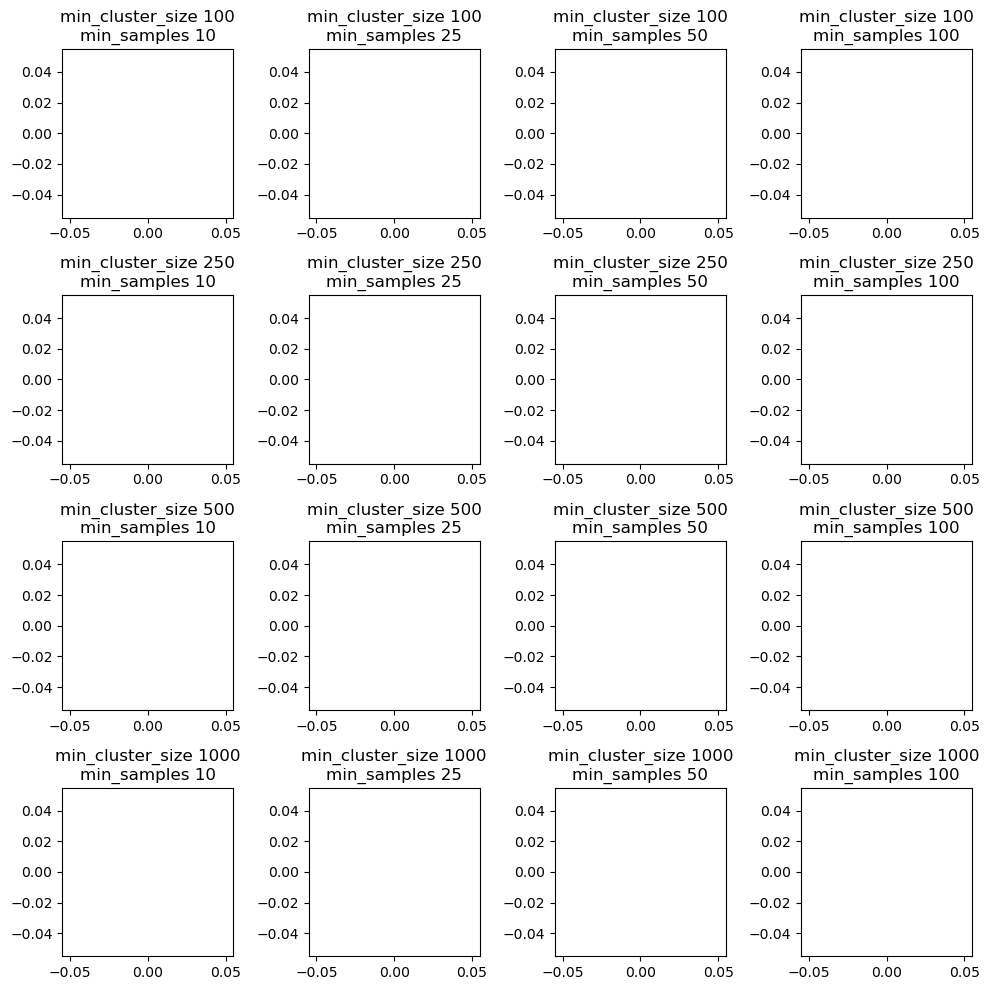

In [31]:
data = embeddings[10]
analyze_hdbscan_params(
    data,
    get_fraction_samples(data),
    get_fraction_samples(data, [0.001, 0.0025, 0.005, 0.01])
)

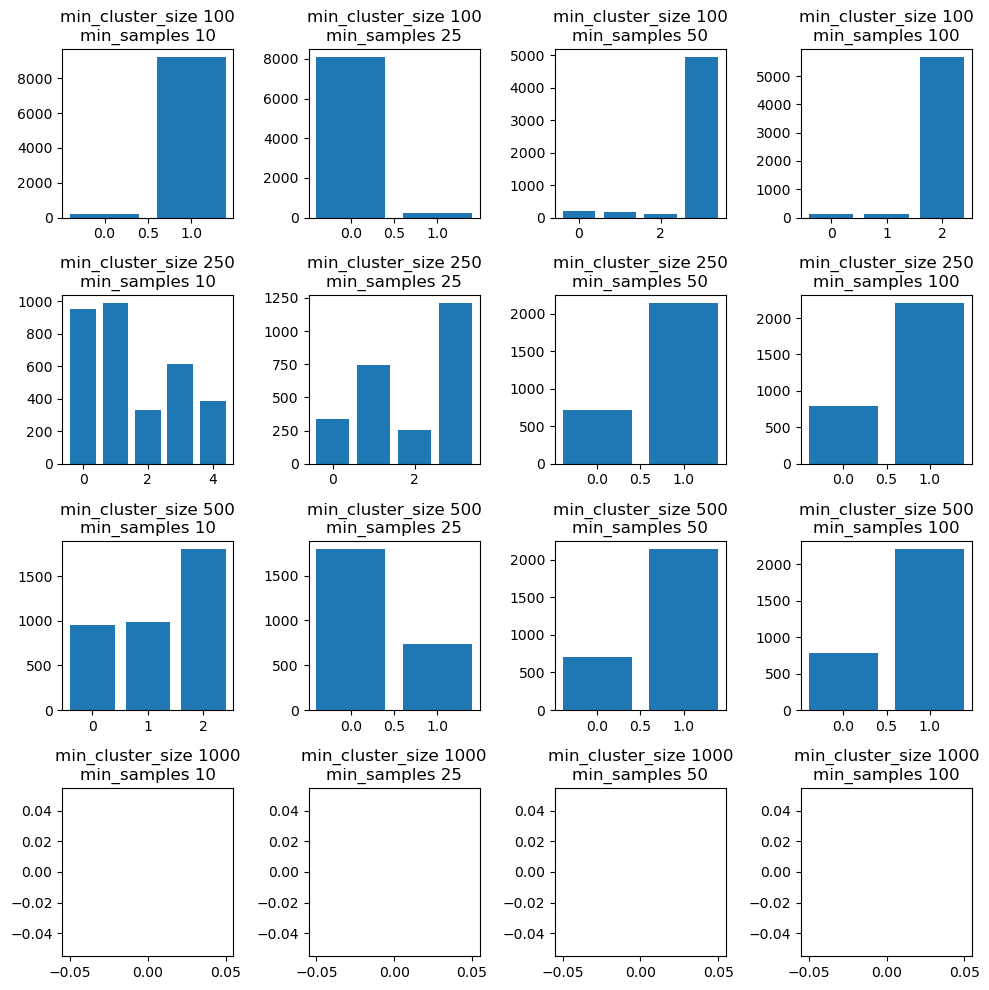

In [32]:
data = embeddings_proj[10]
analyze_hdbscan_params(
    data,
    get_fraction_samples(data),
    get_fraction_samples(data, [0.001, 0.0025, 0.005, 0.01])
)

/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


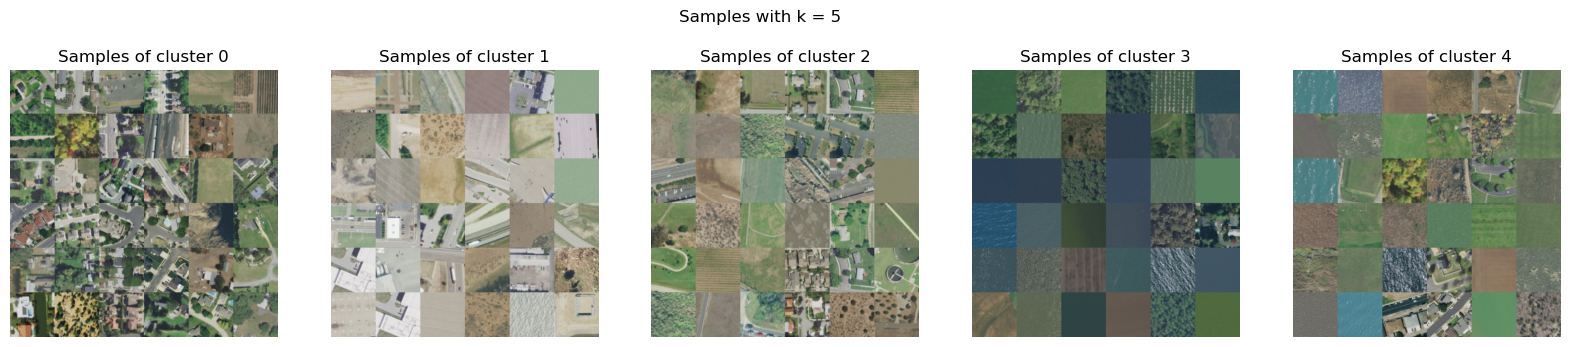

In [37]:
cls = hdbscan.HDBSCAN(min_cluster_size=250, min_samples=10)
cls.fit(embeddings_proj[10])

visualize_cluster_samples(cls.labels_.max() + 1, cls.labels_, n_samples = 36)

## Latent dim = 32

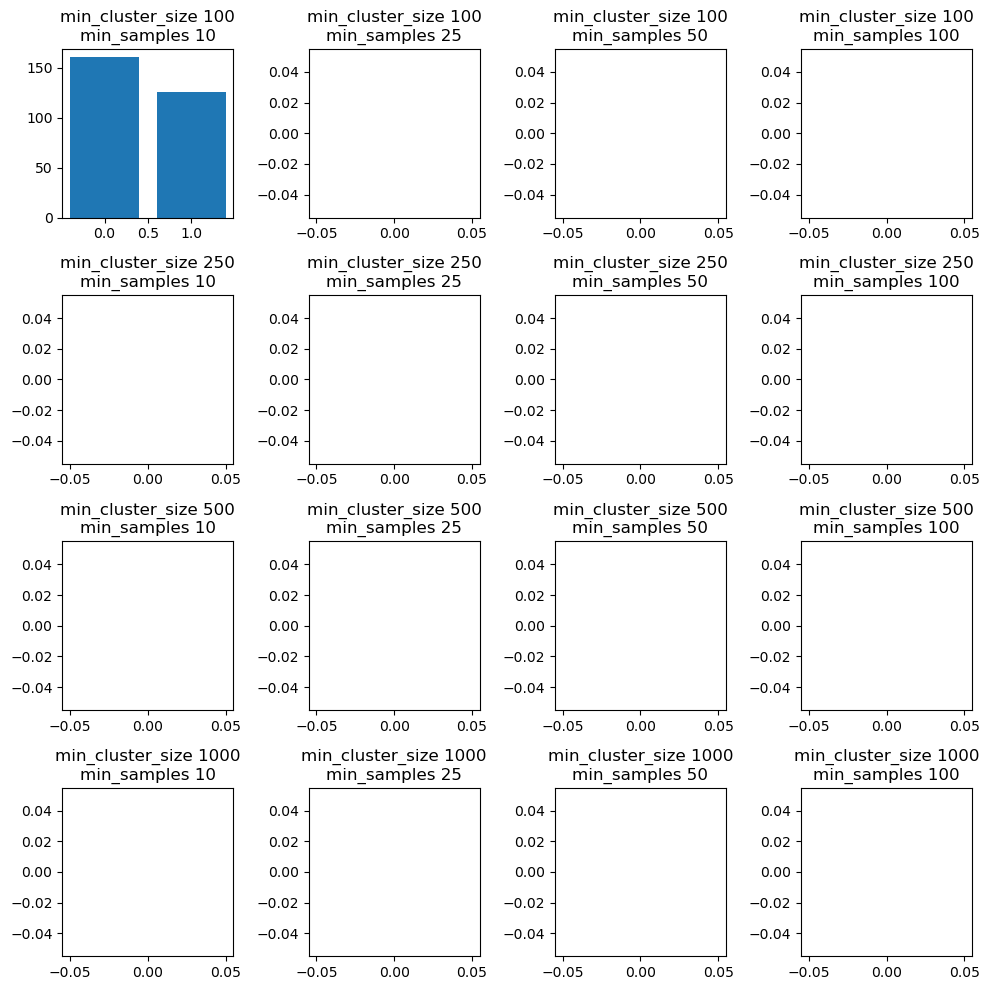

In [33]:
data = embeddings[32]
analyze_hdbscan_params(
    data,
    get_fraction_samples(data),
    get_fraction_samples(data, [0.001, 0.0025, 0.005, 0.01])
)

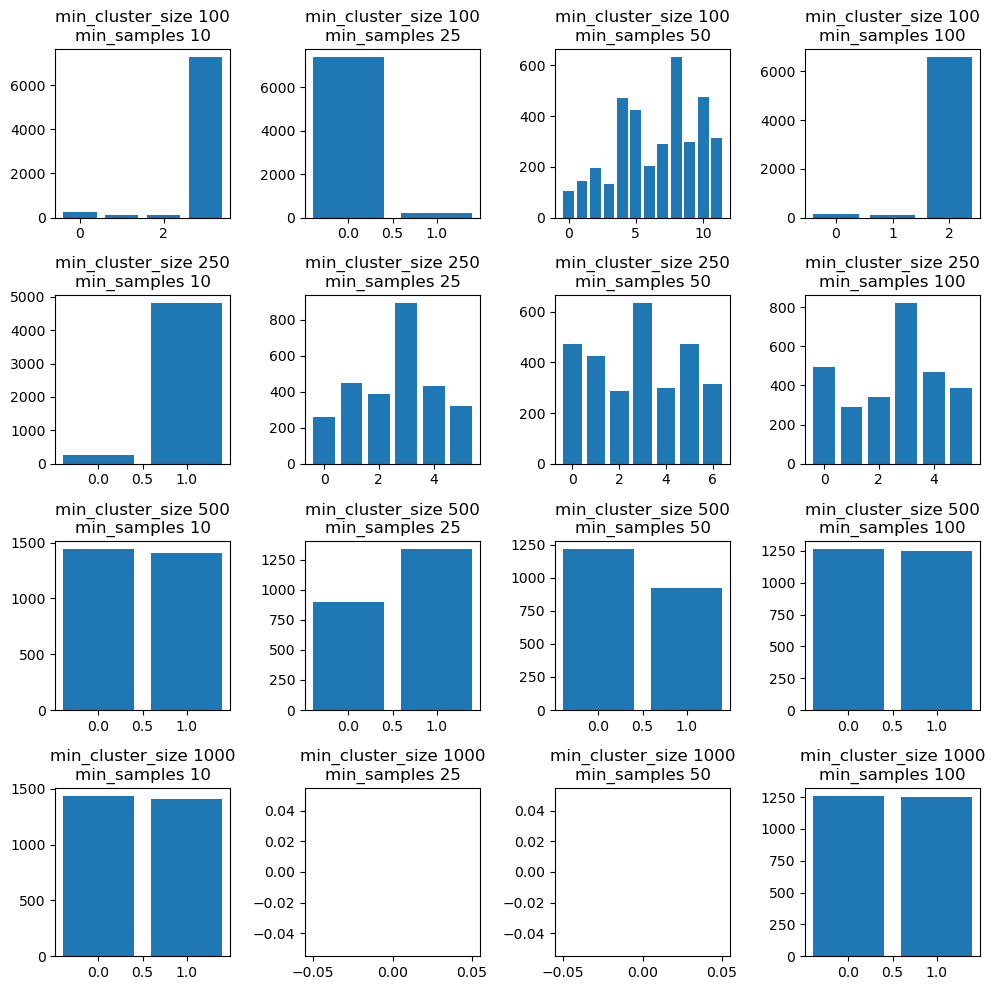

In [34]:
data = embeddings_proj[32]
analyze_hdbscan_params(
    data,
    get_fraction_samples(data),
    get_fraction_samples(data, [0.001, 0.0025, 0.005, 0.01])
)

/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


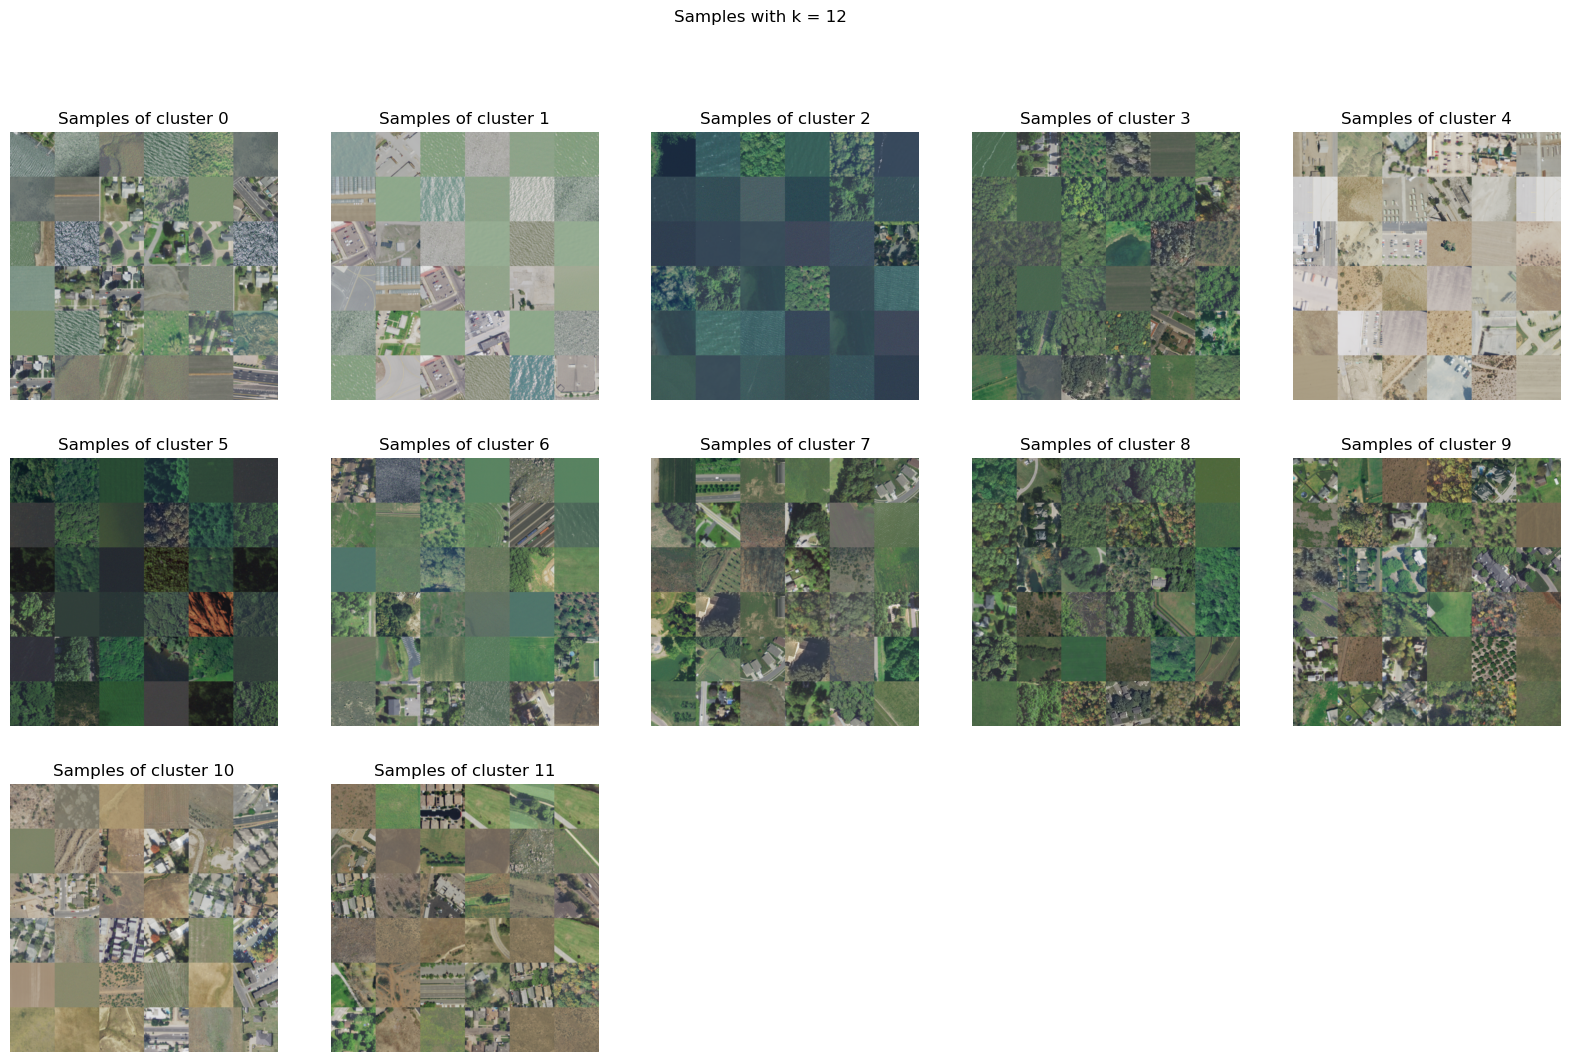

In [39]:
cls = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=50)
cls.fit(embeddings_proj[32])

visualize_cluster_samples(cls.labels_.max() + 1, cls.labels_, n_samples = 36)

/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


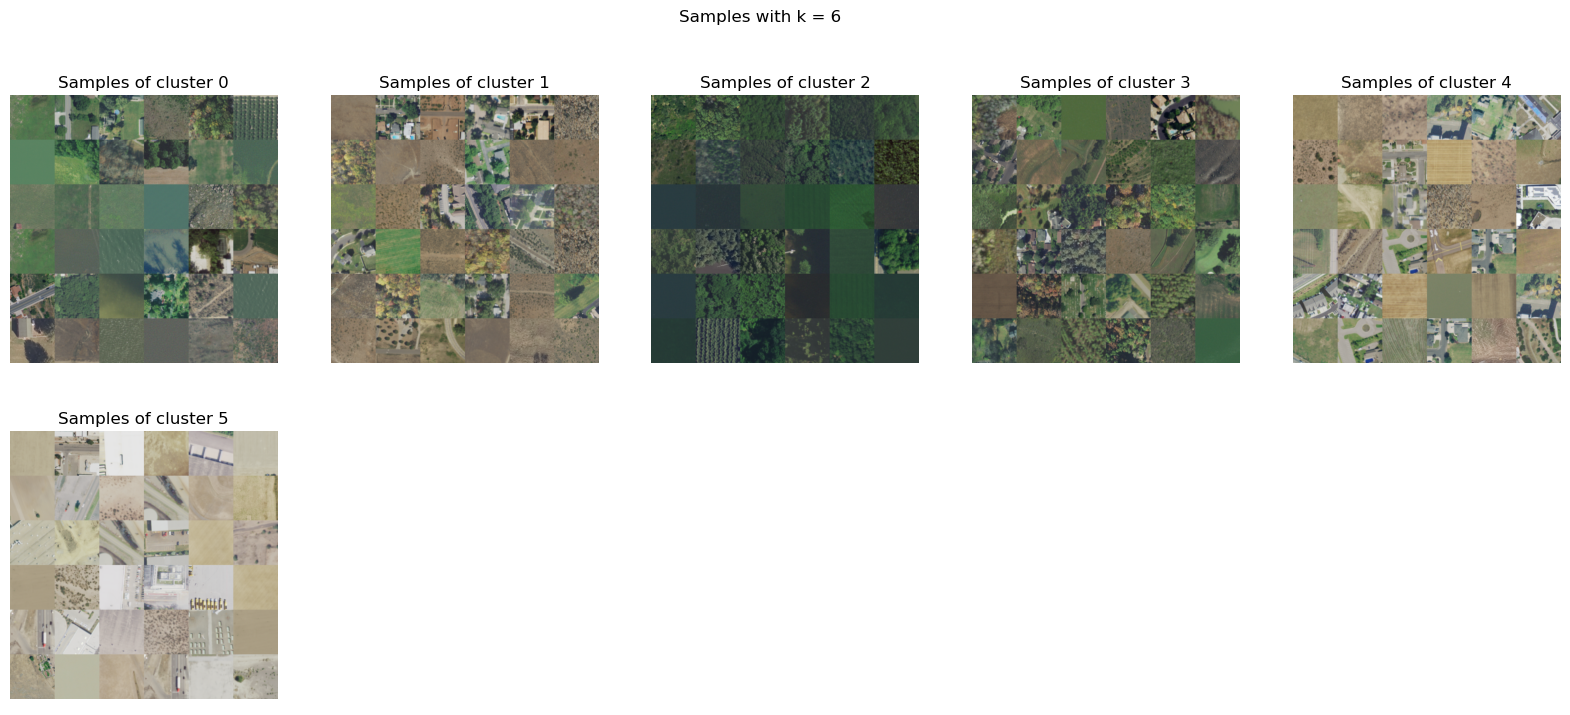

In [38]:
cls = hdbscan.HDBSCAN(min_cluster_size=250, min_samples=100)
cls.fit(embeddings_proj[32])

visualize_cluster_samples(cls.labels_.max() + 1, cls.labels_, n_samples = 36)

## Latent dim = 64

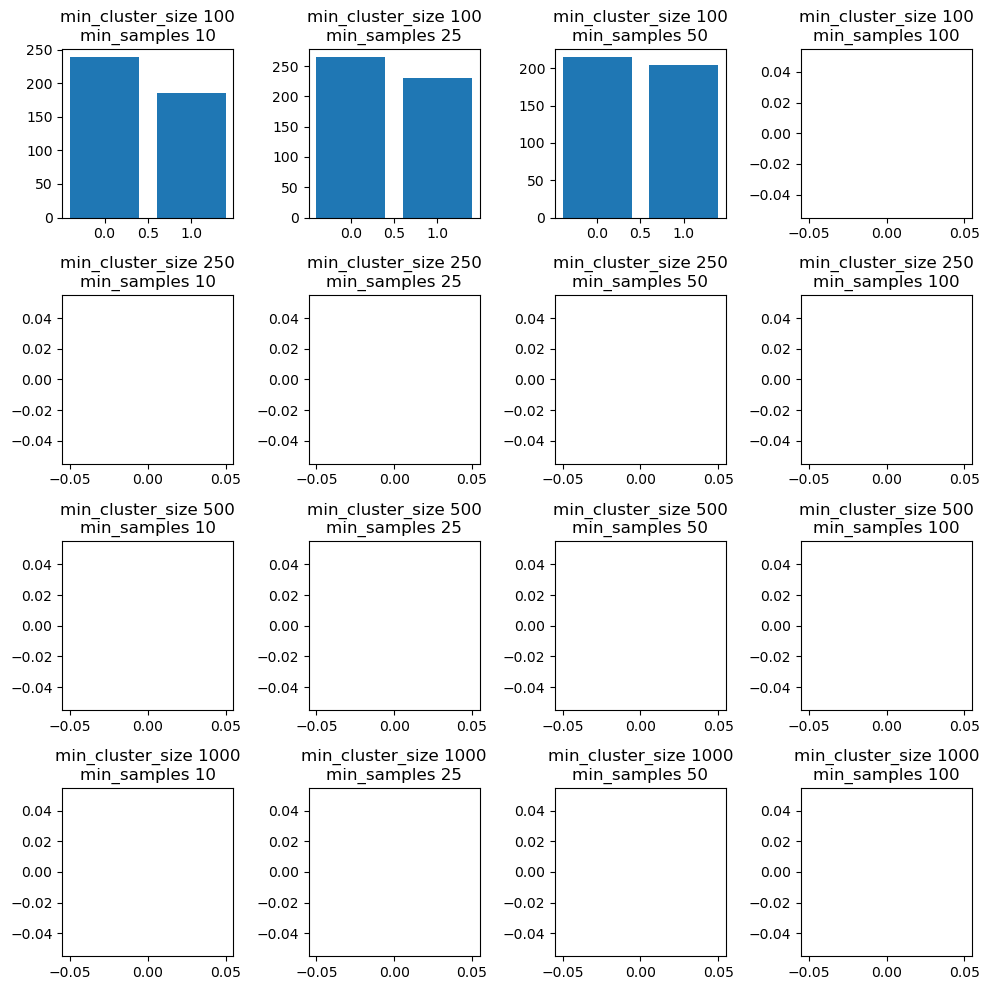

In [35]:
data = embeddings[64]
analyze_hdbscan_params(
    data,
    get_fraction_samples(data),
    get_fraction_samples(data, [0.001, 0.0025, 0.005, 0.01])
)

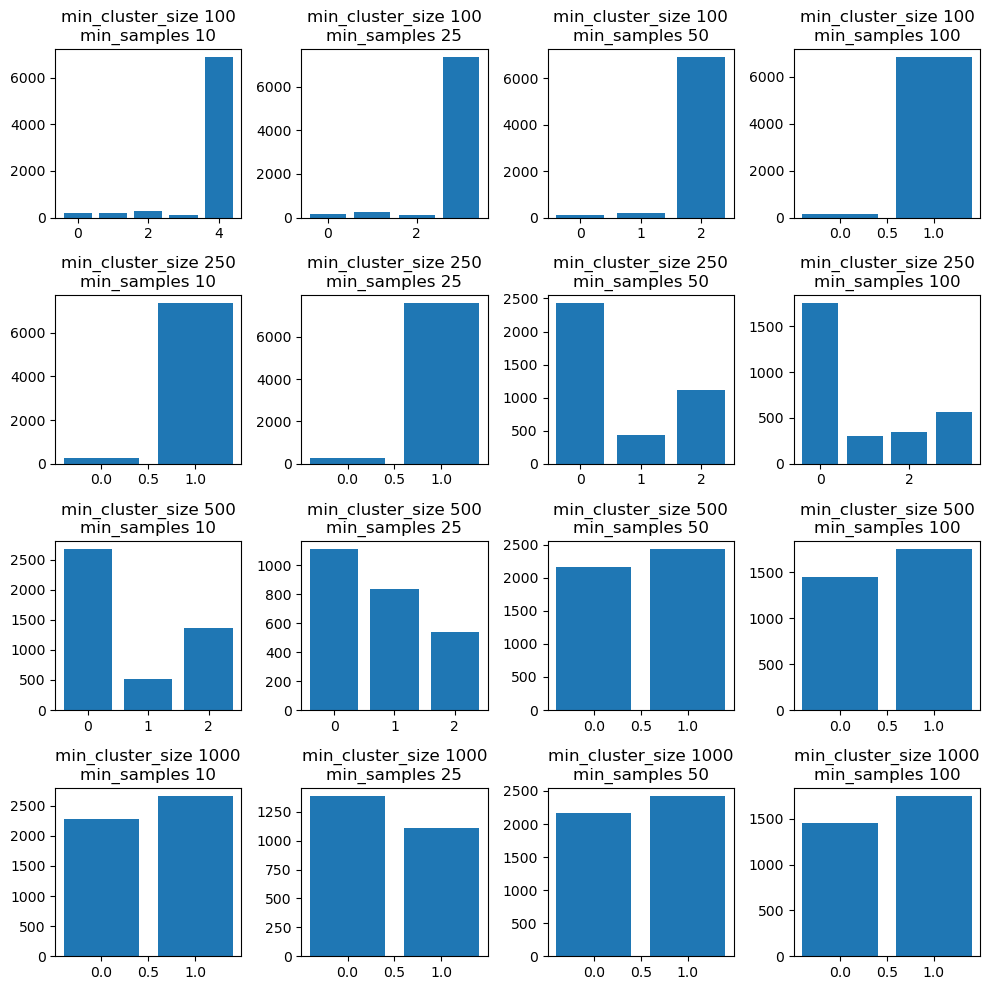

In [36]:
data = embeddings_proj[64]
analyze_hdbscan_params(
    data,
    get_fraction_samples(data),
    get_fraction_samples(data, [0.001, 0.0025, 0.005, 0.01])
)

/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


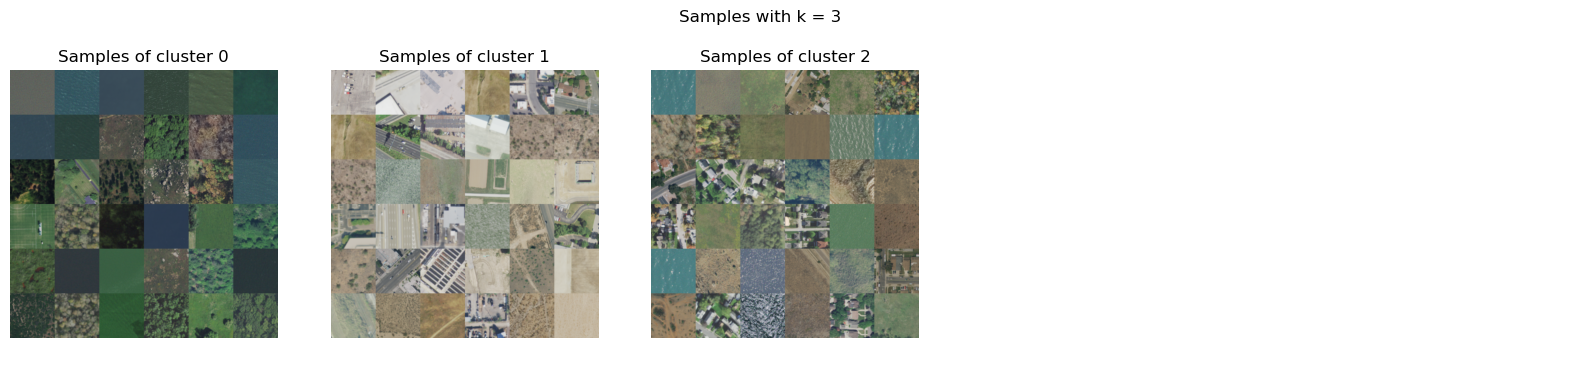

In [40]:
cls = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=25)
cls.fit(embeddings_proj[64])

visualize_cluster_samples(cls.labels_.max() + 1, cls.labels_, n_samples = 36)